# Node-centric expression models (NCEM)

This tutorial shows how to leverage NCEM to understand cell communication in spatial graphs of cells. We will introduce several concepts also mentioned in our preprint Learning cell communication from spatial graphs of cells (Fischer, Schaar, Theis, 2021).

This notebook uses spatial data available in :mod:`squidpy.datasets` that has been pre-processed (and pre-formatted). More information on how to store spatial data in :class:`anndata.AnnData` can be found in the `squidpy` tutorial or in the documentation.

## Imports
We start by loading all packages used in this tutorial. NCEM can be installed with `pip install ncem` which automatically loads all required dependencies.

In [11]:
%load_ext autoreload
%autoreload 2

import ncem as nc
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq

sc.settings.set_figure_params(dpi=80)

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this tutorial, we mainly focus on the linear NCEM interaction model and we will show how to use the `customLoader` class to feed any dataset into ncem. 

In [2]:
from ncem.interpretation import InterpreterInteraction
from ncem.data import get_data_custom, customLoader

## Dataset

This tutorial runs on a pre-processed MIBI-TOF dataset from Hartmann et al. which can be called fram :mod:`sq.datasets` which has been subsetted to three images. For details on how it was pre-processed, please refer to the original paper. The subset of the data we consider here comprises three biopsies colorectal carcinoma biopsies from different donors, where MIBI-TOF was used to measure single-cell metabolic profiles. 

NCEM can be run on subsets of images as well as the complete dataset depending on the analysis workflow and goal. 

In [3]:
ad = sq.datasets.mibitof()

As a next step, we now call the NCEM interpreter class for interaction models. The :class:`InterpreterInteraction()` calls a linear model that predicts gene expression states from a graph of categorical cell type labels. This model is trailored to find putative sender-receiver dependencies at intermediate length scales. 

In [4]:
ncem = InterpreterInteraction()

The NCEM package incldues several different data loader classes that can be called after downloading the respective datasets from the original publication. In this tutorial, we will show how to use the :class:`customLoader` that generates a NCEM data object from an :class:`anndata.AnnData` object. The data needs to have cell type annotation stored in `.obs` as categorical cell types are required to run all NCEMs. Additionally, one can provide columns in `.obs` that specify the patient and the library identifier. The dataset we are using here has both donor as well as library id information. 

According to the original publication by Hartmann et al., the dataset has a resolution of 400 x 400 $\mu m$ over 1024 x 1024 pixels where the unit of the spatial coordinates in the dataset are given in pixels. NCEM functions on this same unit as provided by the spatial information. We showed that cells communicate at intermediate length scales, for this reason we select the resolution of potential interactions as 52 pixels. This translates to approximately 20 $\mu m$ which matches the distance of the computationally identified tumor–immune border according to Hartmann et al.

In [5]:
ncem.data = customLoader(
    adata=ad, cluster='Cluster', patient='donor', library_id='library_id', radius=52
)
get_data_custom(interpreter=ncem)

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 34.99it/s]

Loaded 3 images with complete data from 2 patients over 3309 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 9.969315
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 3309 cells out of 3 images from 2 patients.
Test dataset: 330 cells out of 3 images from 2 patients.
Training dataset: 2695 cells out of 3 images from 2 patients.
Validation dataset: 298 cells out of 3 images from 2 patients. 



## Variance decomposition

NCEM relates intra cell type variance to niche information. We, therefore, inspect the image-wise variance decomposition in the data. For the shown dataset, we inspect 

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


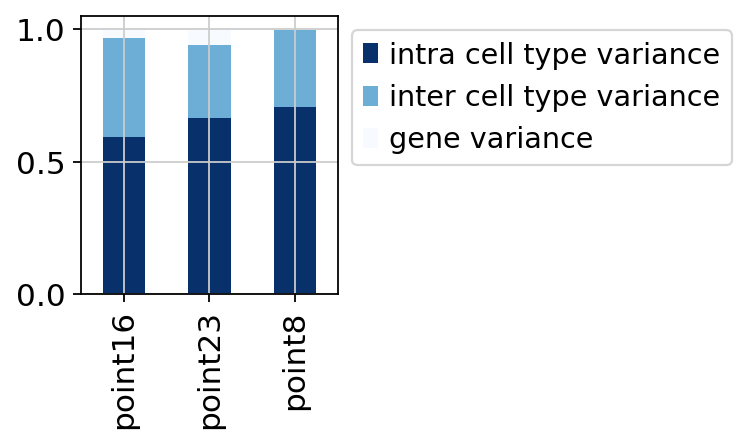

In [6]:
var_decomp = ncem.data.compute_variance_decomposition()
ncem.data.variance_decomposition(var_decomp, figsize=(5,3))

In [7]:
var_decomp.mean(axis=0)[['intra cell type variance', 'inter cell type variance', 'gene variance']]

intra cell type variance    0.653940
inter cell type variance    0.312406
gene variance               0.033654
dtype: float32

As this dataset was preprocessed, we inspect a relativly high intra cell type variance. In general, NCEM tries to explain intra cell type variance by accounting it to the niche composition. 

## Cell heterogeneity attributed to niche composition

NCEM provides the user with several analysis tools that help to understand niche composition and putative sender-receiver dependencies. We first compute a cluster enrichment analysis on the data on CD8 T cells. This analysis can be performed on any cell type present in the dataset to attribute cell heterogeneity to niche composition. 

In [8]:
adata_img, adata, log_pval, fold_change = ncem.data.compute_cluster_enrichment(
    image_key=['point16', 'point23', 'point8'],
    target_cell_type='Tcell_CD8',
    clip_pvalues=-5,
    n_neighbors=22,
    n_pcs=None,
    #filter_titles=filter_titles
)

100%|███████████████████████████████████████████| 14/14 [00:08<00:00,  1.66it/s]


n cells:  464
Tcell_CD8 0    145
Tcell_CD8 1    117
Tcell_CD8 2     79
Tcell_CD8 3     69
Tcell_CD8 4     54
Name: Tcell_CD8 substates, dtype: int64


... storing 'donor' as categorical
... storing 'library_id' as categorical


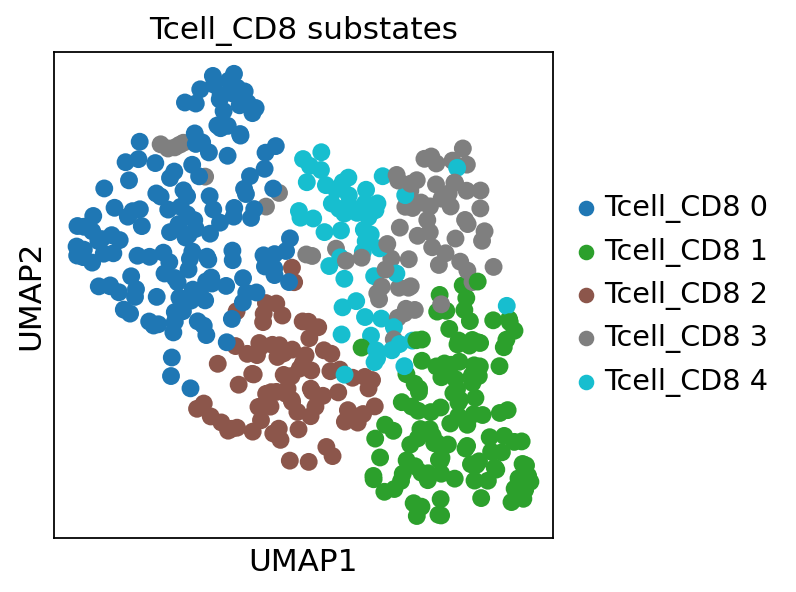

In [9]:
sc.pl.umap(adata, color='Tcell_CD8 substates', palette='tab10')

The cluster enrichment analysis find substates for a given cell type. We can inspect that cell heterogeneity of CD8 T cells attributes to niche composition by looking at the spatial allocation of respective substates and additionally by looking at the presents of neighboring Epithelial cells. 

... storing 'donor' as categorical
... storing 'library_id' as categorical
... storing 'donor' as categorical
... storing 'library_id' as categorical
... storing 'donor' as categorical
... storing 'library_id' as categorical


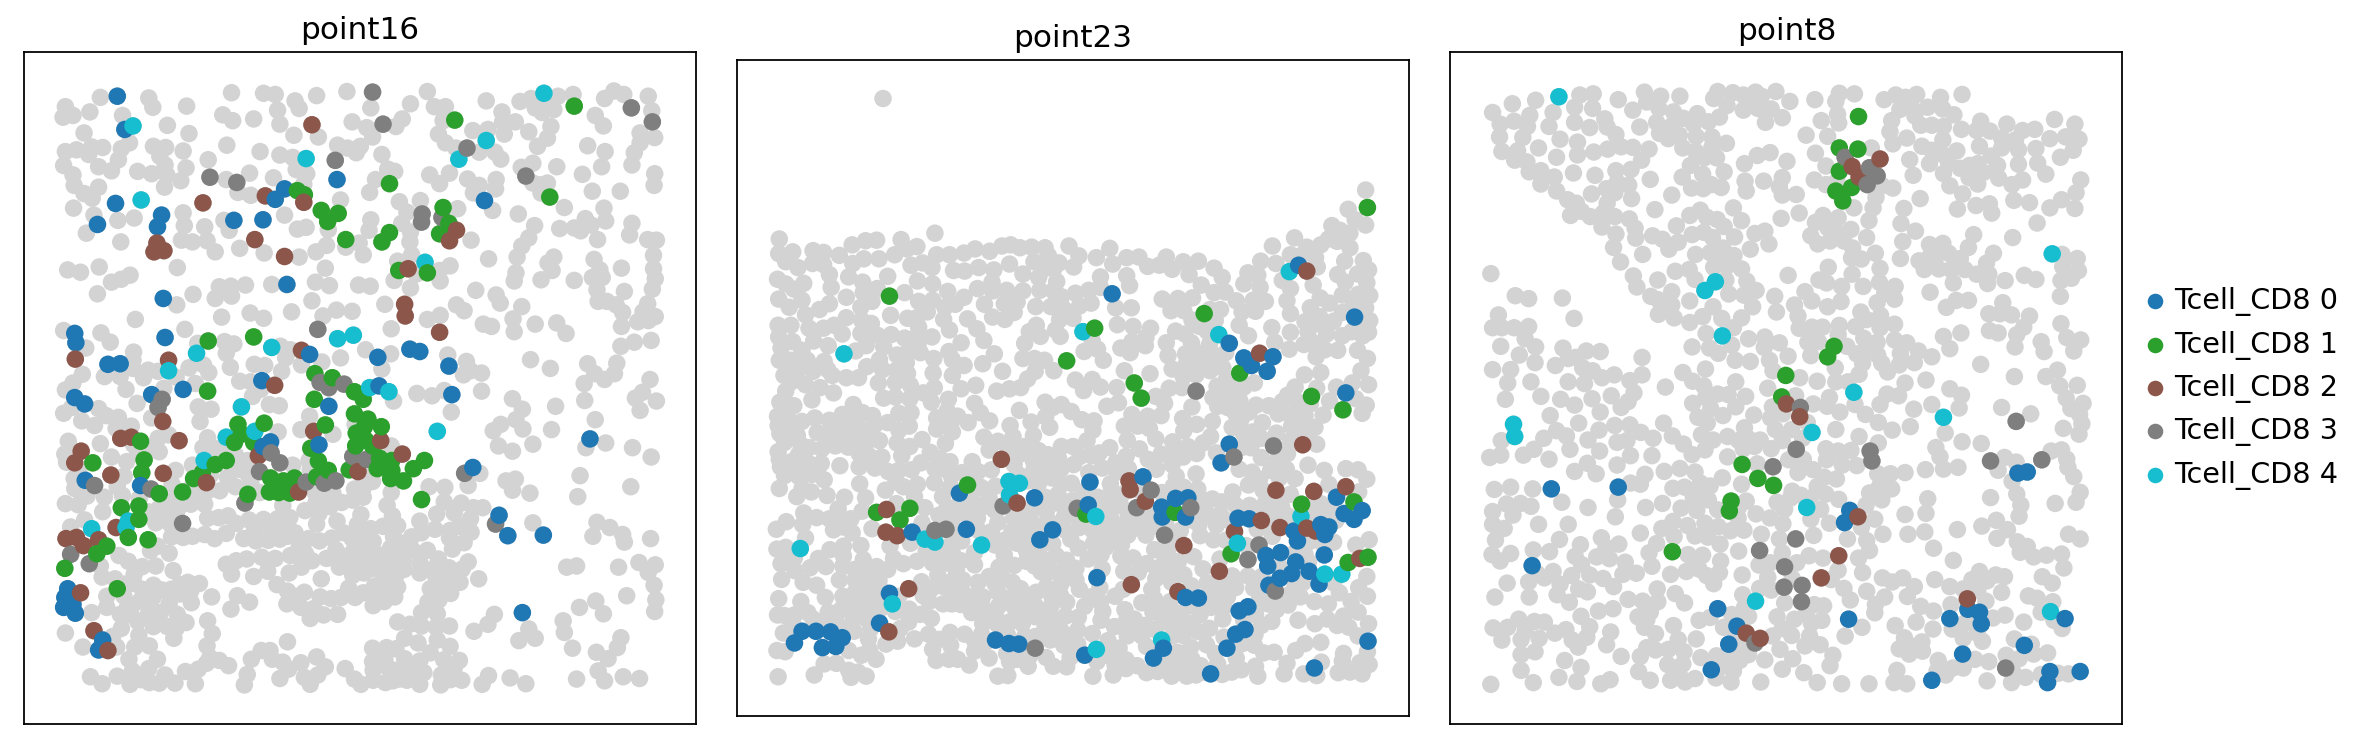

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
ax = ax.ravel()
for i, k in enumerate(['point16', 'point23', 'point8']):
    temp_adata = adata[adata.obs.library_id == k].copy()
    sc.pl.spatial(
        adata_img[adata_img.obs.library_id == k].copy(),
        spot_size=30,
        ax=ax[i],
        show=False,
        title=''
    )
    sc.pl.spatial(
        adata[adata.obs.library_id == k].copy(),
        color='Tcell_CD8 substates',
        spot_size=30,
        ax=ax[i],
        legend_loc='right margin' if i==2 else None,
        show=False,
        title=k,
        palette='tab10'
    )
    ax[i].invert_yaxis()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.tight_layout()
plt.show()

... storing 'donor' as categorical
... storing 'library_id' as categorical
... storing 'donor' as categorical
... storing 'library_id' as categorical
... storing 'donor' as categorical
... storing 'library_id' as categorical


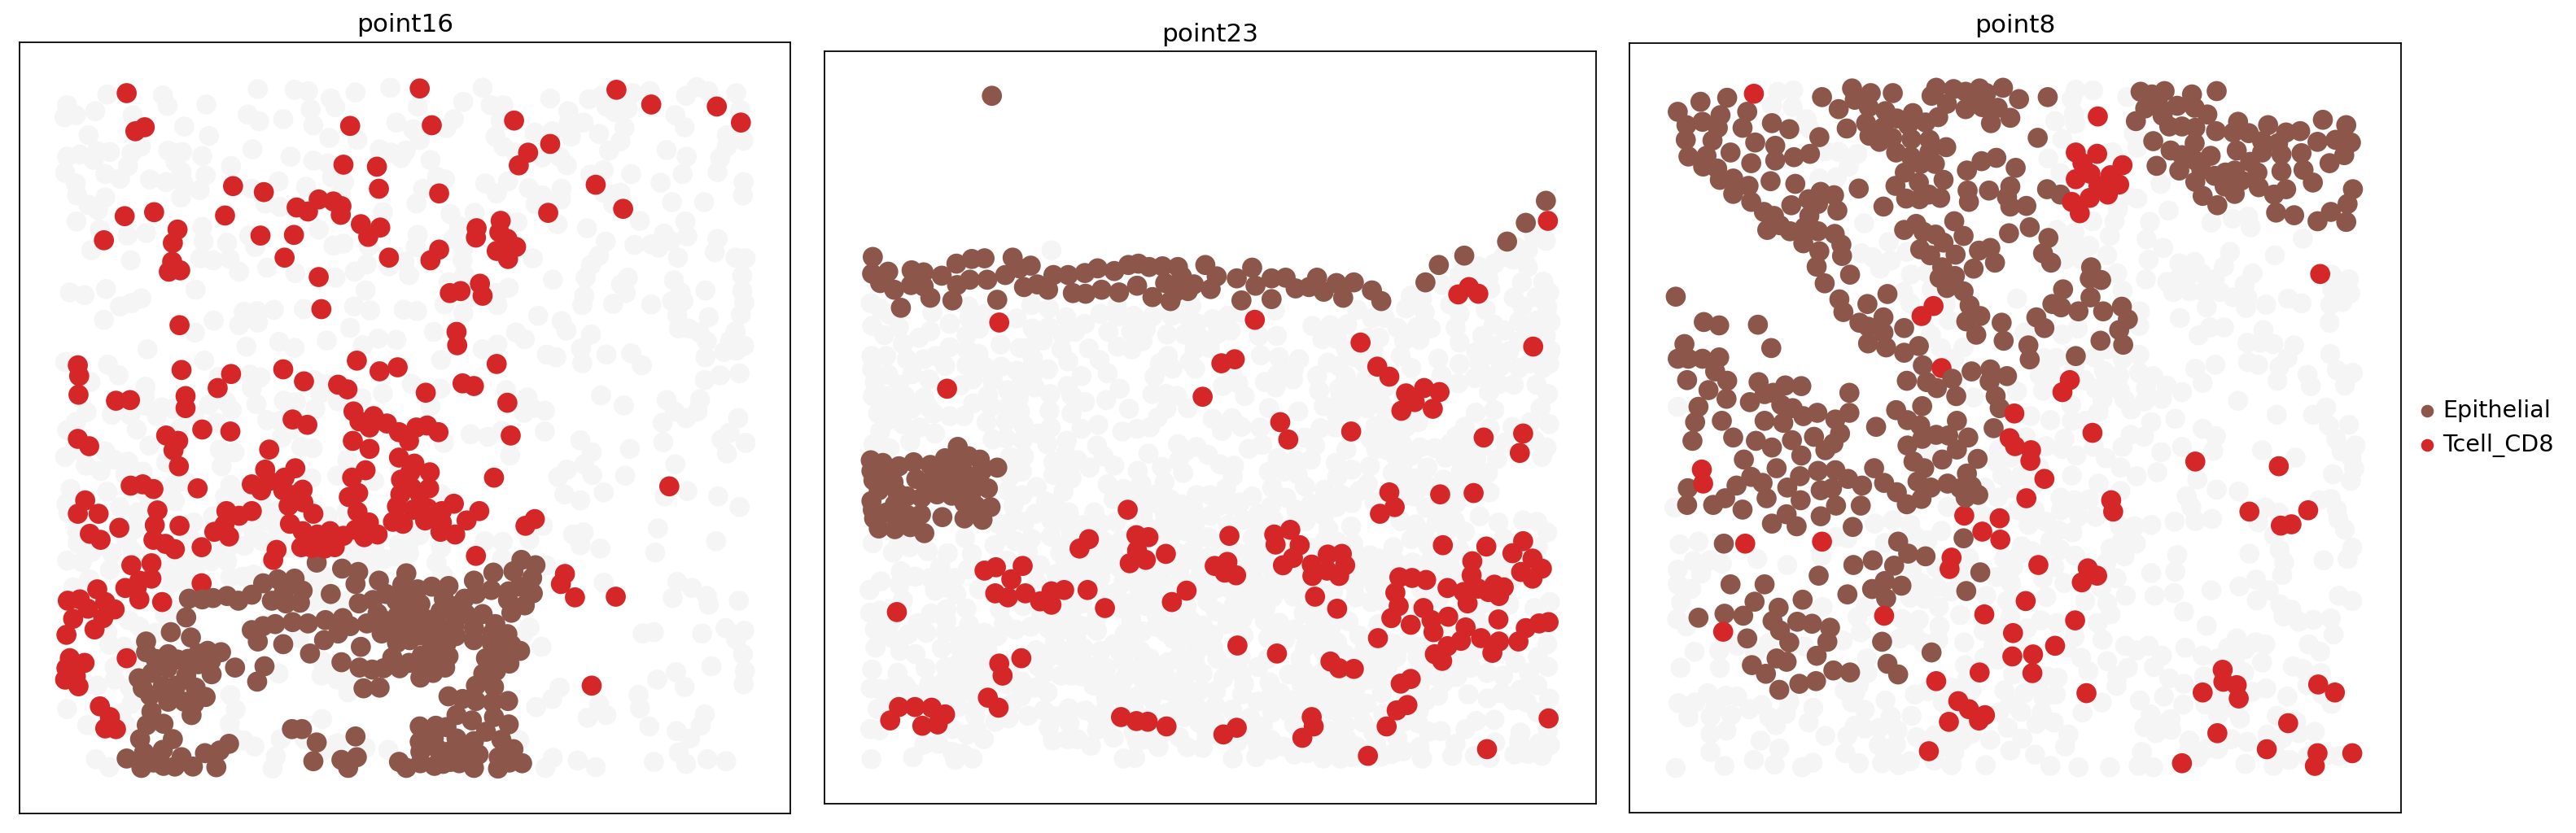

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
ax = ax.ravel()
for i, k in enumerate(['point16', 'point23', 'point8']):
    temp_adata = adata_img[adata_img.obs['library_id'] == k].copy()
    
    sc.pl.spatial(
        temp_adata,
        spot_size=30,
        ax=ax[i],
        show=False,
        na_color='whitesmoke',
        title=''
    )
    sc.pl.spatial(
        temp_adata[temp_adata.obs.Cluster.isin(['Epithelial', 'Tcell_CD8'])].copy(),
        color='Cluster',
        spot_size=30,
        ax=ax[i],
        show=False,
        legend_loc='right margin' if i==2 else None,
        title=k,
        palette={'Epithelial': '#8c564b', 'Tcell_CD8': '#d62728'}
    )
    ax[i].invert_yaxis()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.tight_layout()
plt.show()

We can quantify this, by computing the actual $\log_{10}$-FDR corrected p-values and the fold change between receiver cells where a sender cell is in the neighborhood or not. 

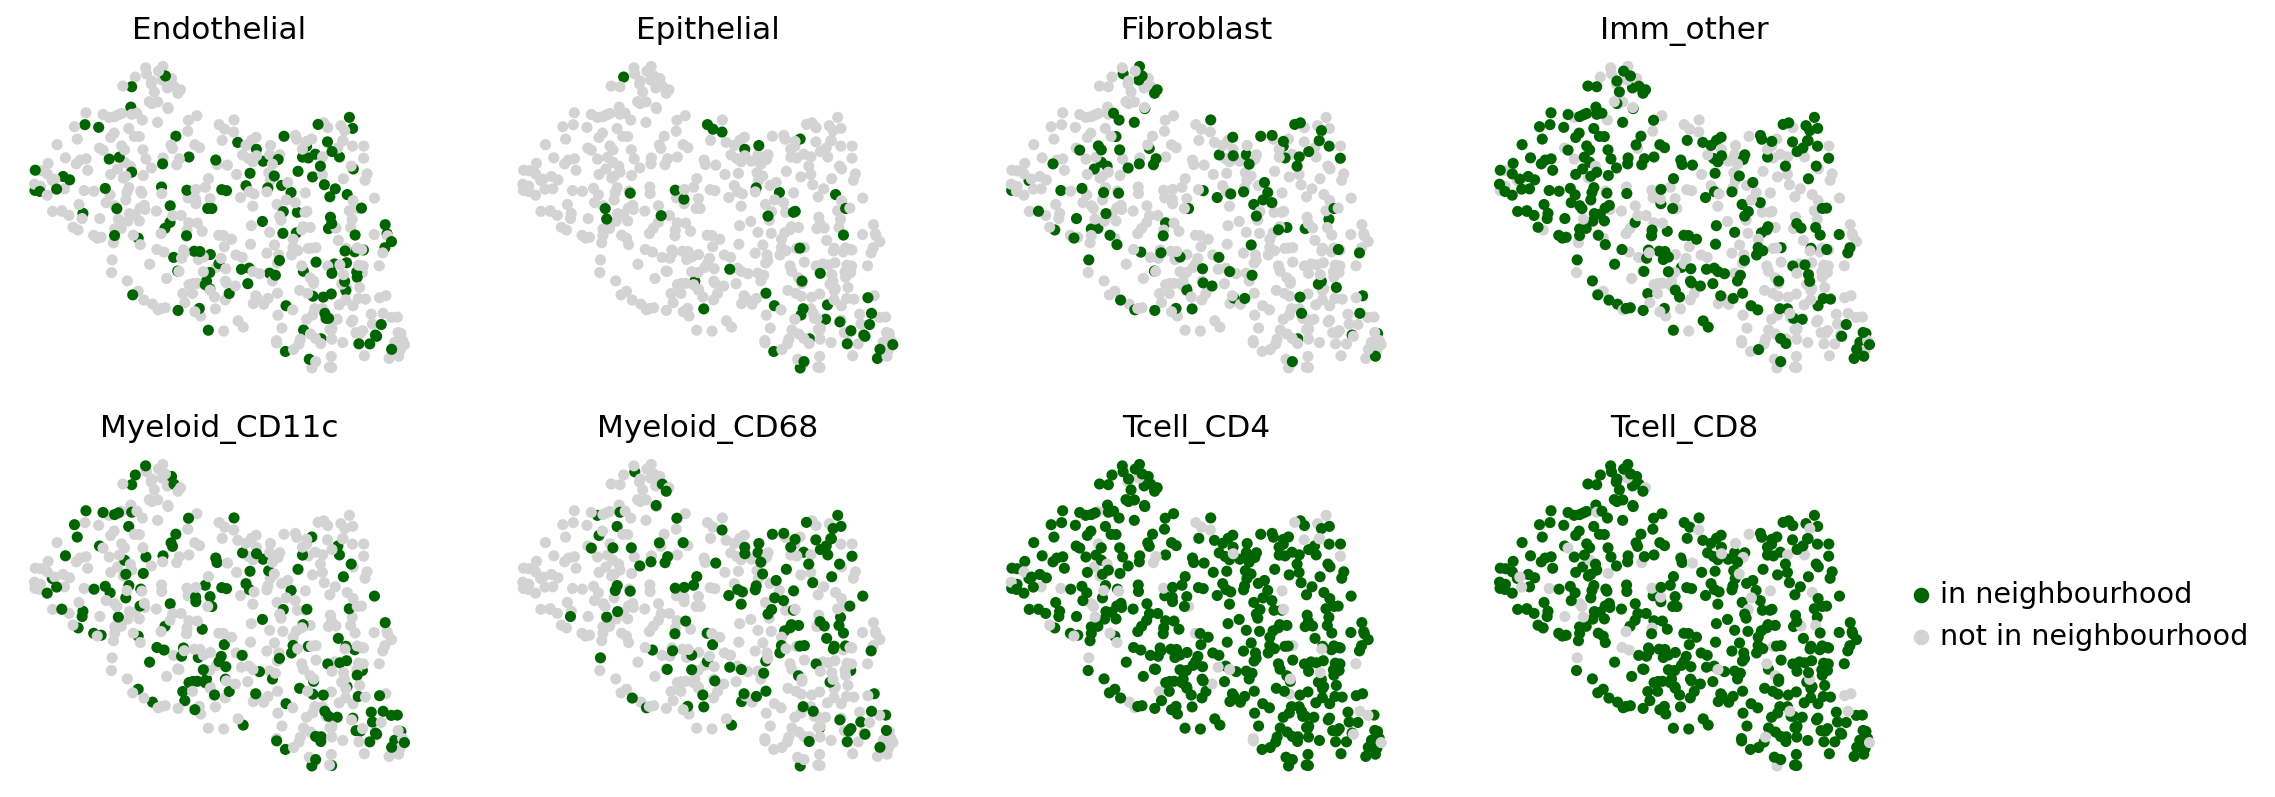

In [19]:
ncem.data.umaps_cluster_enrichment(
    adata, 
    nrows=2,
    ncols=4,
    figsize=(15,6),
    filter_titles=ncem.cell_names,
    size=100
)

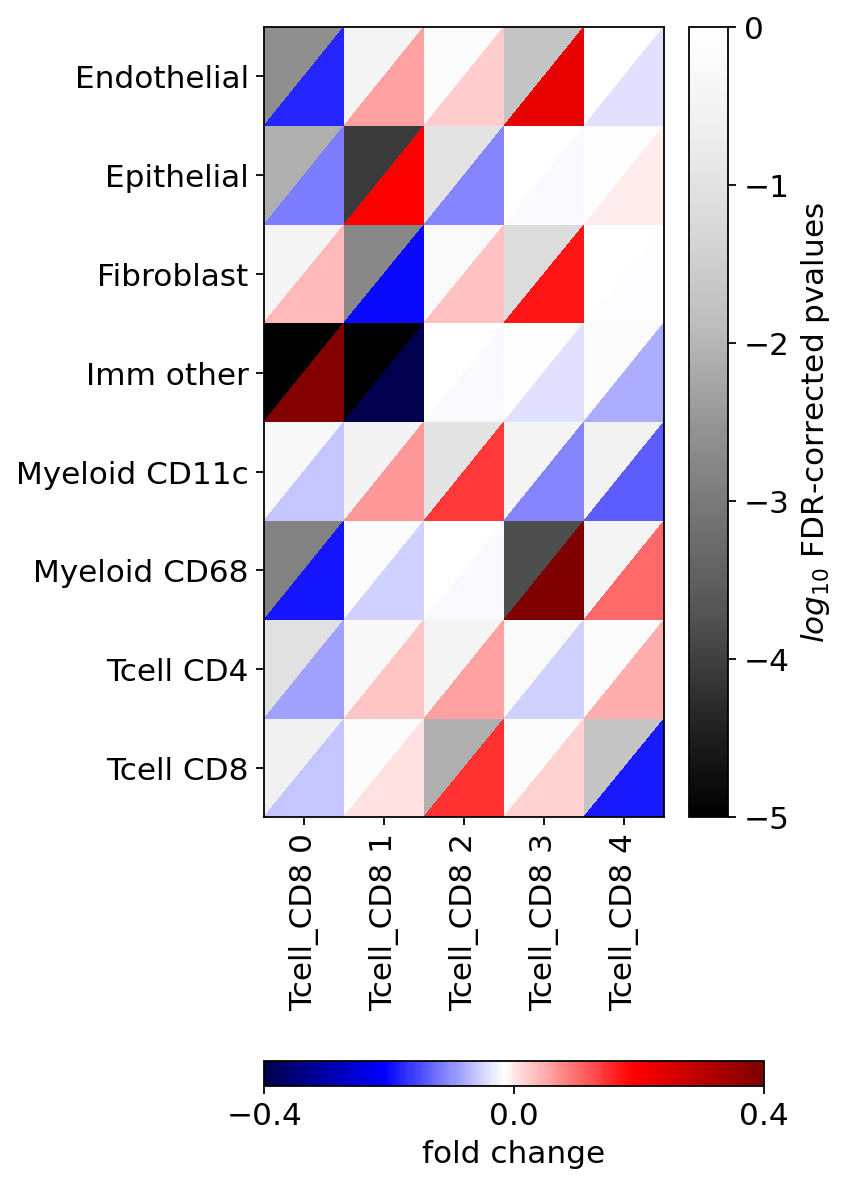

In [20]:
ncem.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    pad=0.2,
    linspace=(-0.4, 0.4, 3)
)

## Type coupling analysis

As a next step, we fit the linear interaction NCEM. 

In [94]:
ncem.get_sender_receiver_effects()

100%|████████████████████████████████████████| 330/330 [00:02<00:00, 162.47it/s]


using ols parameters.
calculating inv fim.


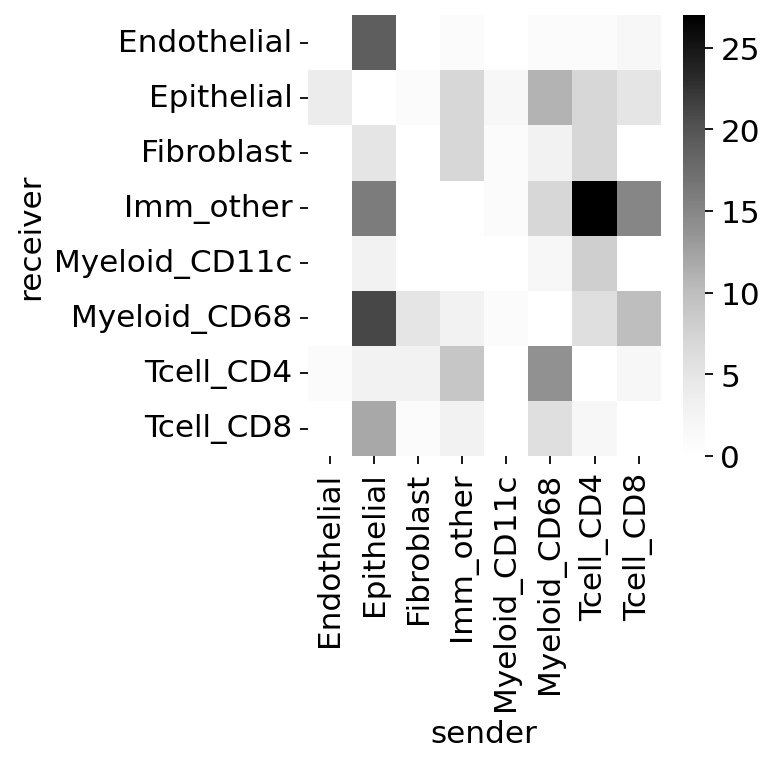

In [95]:
ncem.type_coupling_analysis(figsize=(5, 5))

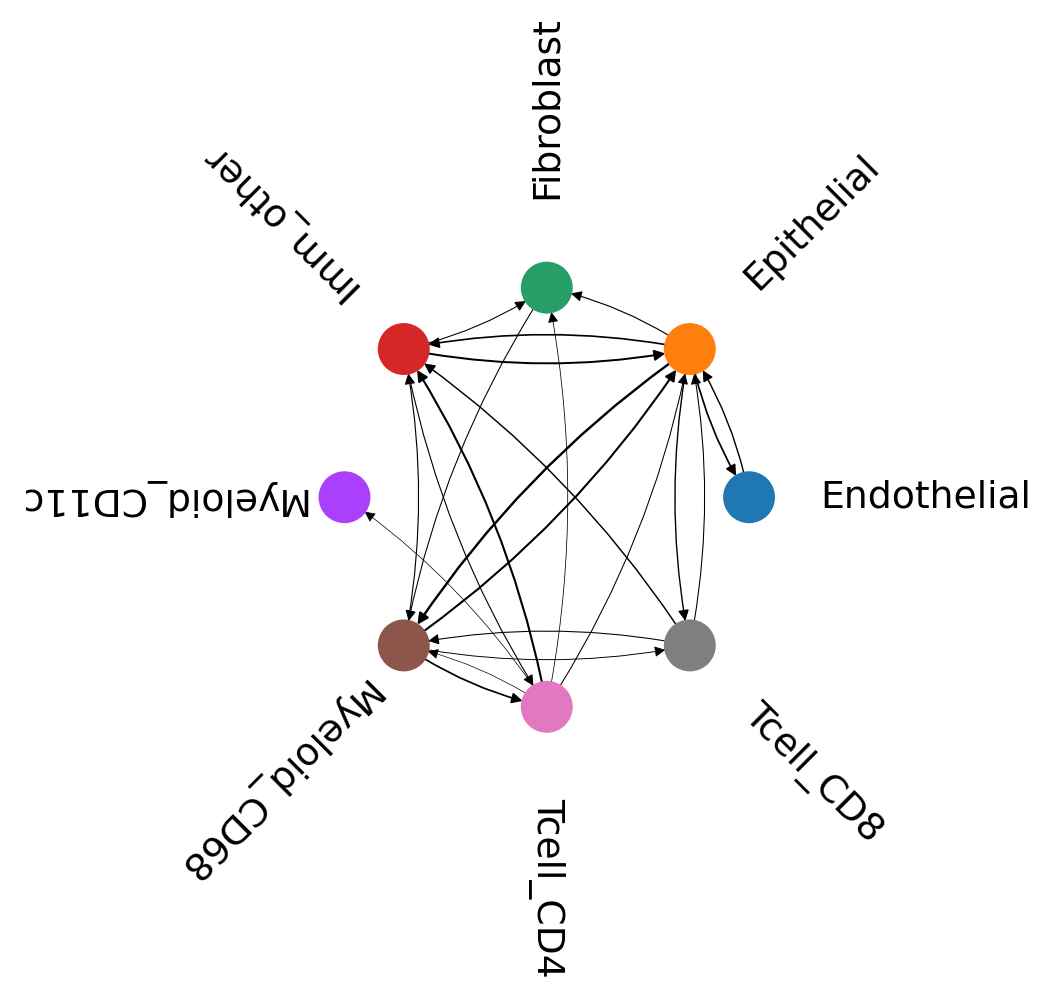

In [96]:
type_coupling = ncem.type_coupling_analysis_circular(
    edge_attr='magnitude', figsize=(9,8), de_genes_threshold=3, text_space=1.78
)

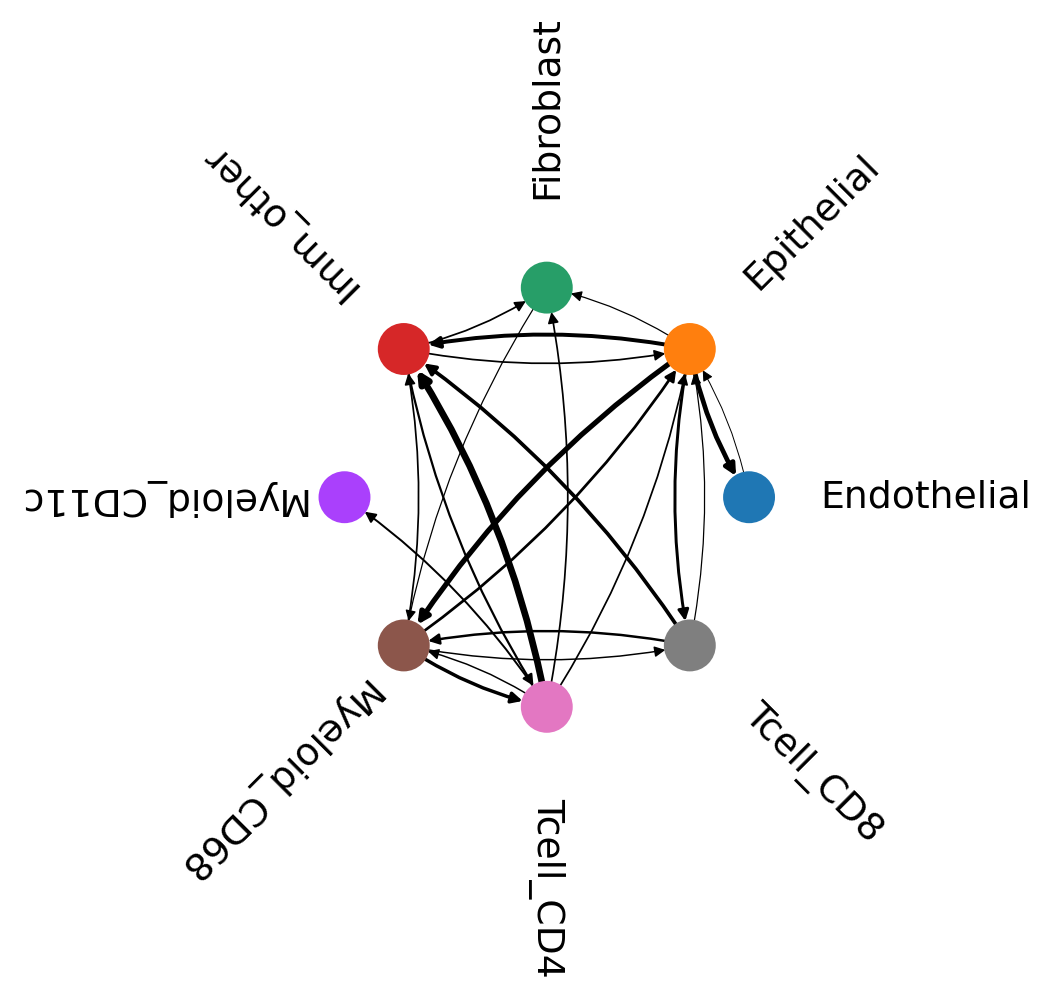

In [97]:
type_coupling = ncem.type_coupling_analysis_circular(
    edge_attr='de_genes', figsize=(9,8), de_genes_threshold=3, text_space=1.78
)

## Putative sender-receiver dependencies

In [108]:
effect_df = ncem.sender_receiver_values(sender='Epithelial', receiver='Tcell_CD8')

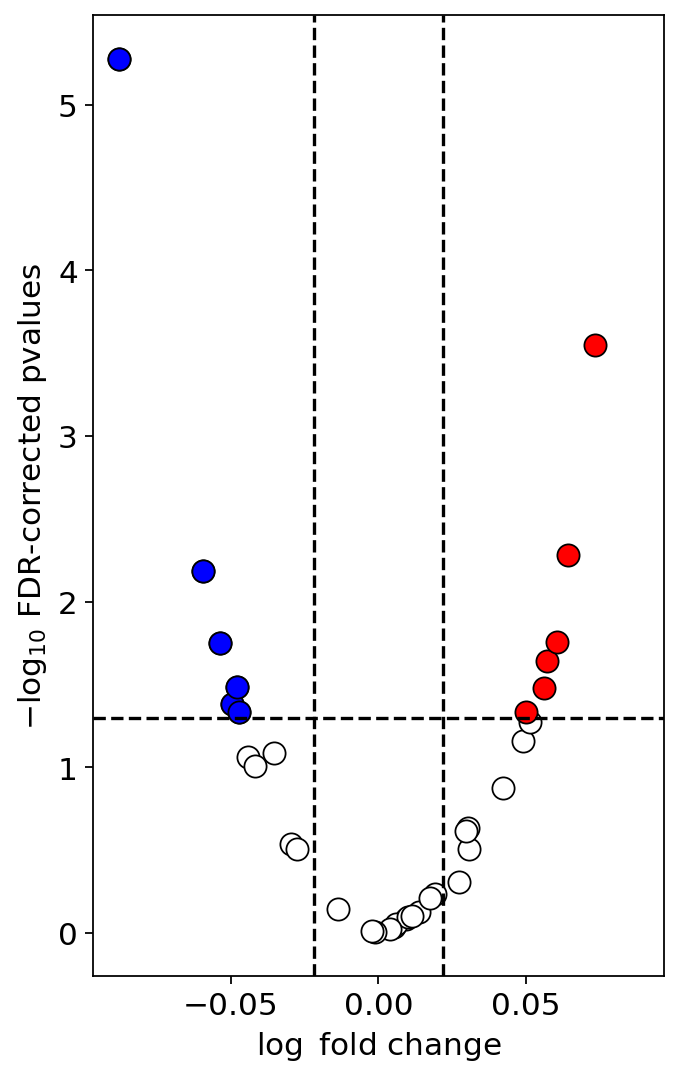

In [109]:
ncem.sender_receiver_effect_vulcanoplot(
    sender='Epithelial', receiver='Tcell_CD8'
)

In [111]:
effect_df[effect_df['qvalue'] <= 0.05]

,mean expression,pvalue,qvalue,fold change,-log 10 qvalue
ATP5A,-0.026972,1.696350e-03,0.017874,-0.053788,1.747785
CD14,0.048974,2.402928e-03,0.022712,0.057011,1.643751
CD8,0.252653,3.920681e-03,0.033102,0.056184,1.480142
CK,-0.110664,5.290298e-03,0.041679,-0.049673,1.380081
CPT1A,-0.028712,3.856793e-03,0.032776,-0.048060,1.484439
H3,0.028327,6.168372e-03,0.046210,-0.047237,1.335262
Ki67,-0.066140,1.191306e-05,0.000281,0.073422,3.551734
PD1,0.126122,1.651702e-03,0.017546,0.060470,1.755823
S6p,0.053882,3.952014e-04,0.005200,0.064332,2.284013
SDHA,-0.023174,1.266377e-07,0.000005,-0.087781,5.276194


In [101]:
gene_subset = effect_df[effect_df['qvalue'] <= 0.05].index

### Sender effect

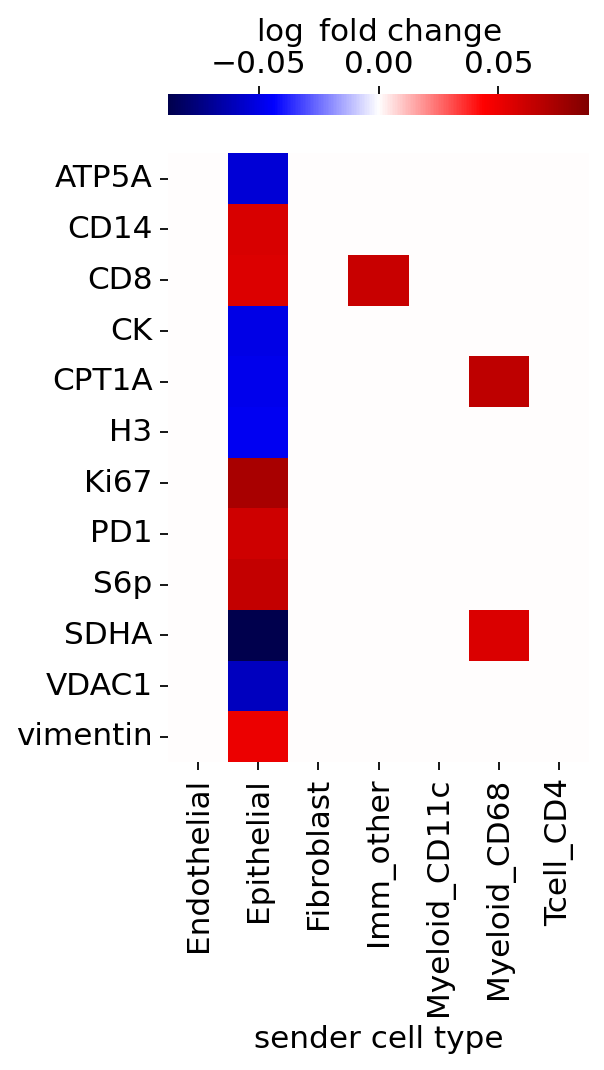

In [102]:
ncem.sender_effect(receiver='Tcell_CD8', gene_subset=list(gene_subset), figsize=(4,7))

### Receiver effect

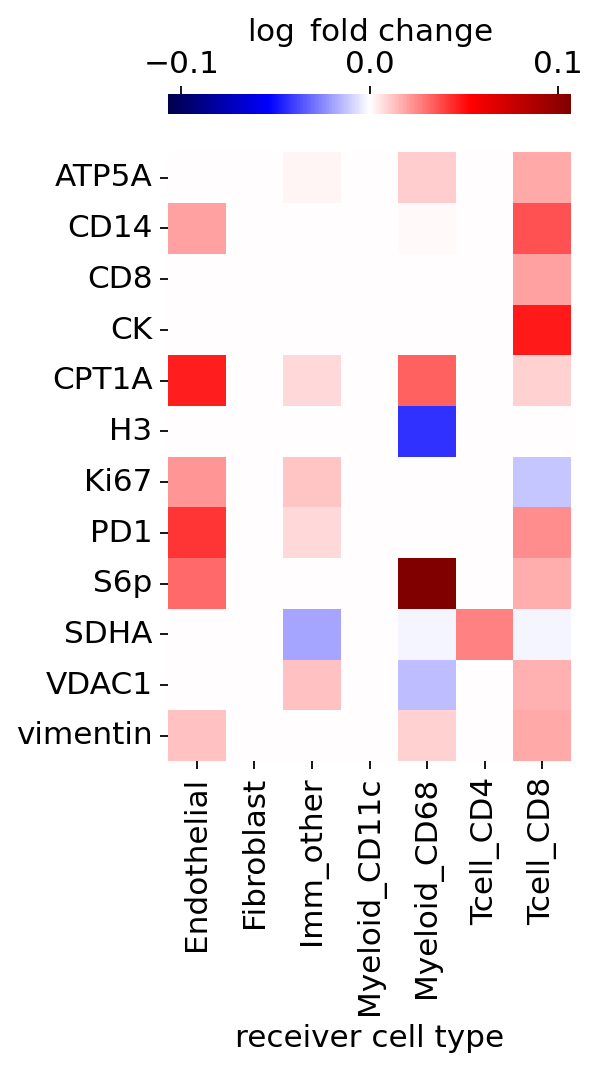

In [104]:
ncem.receiver_effect(sender='Epithelial', gene_subset=list(gene_subset), figsize=(4,7))

### Sender similarity analysis

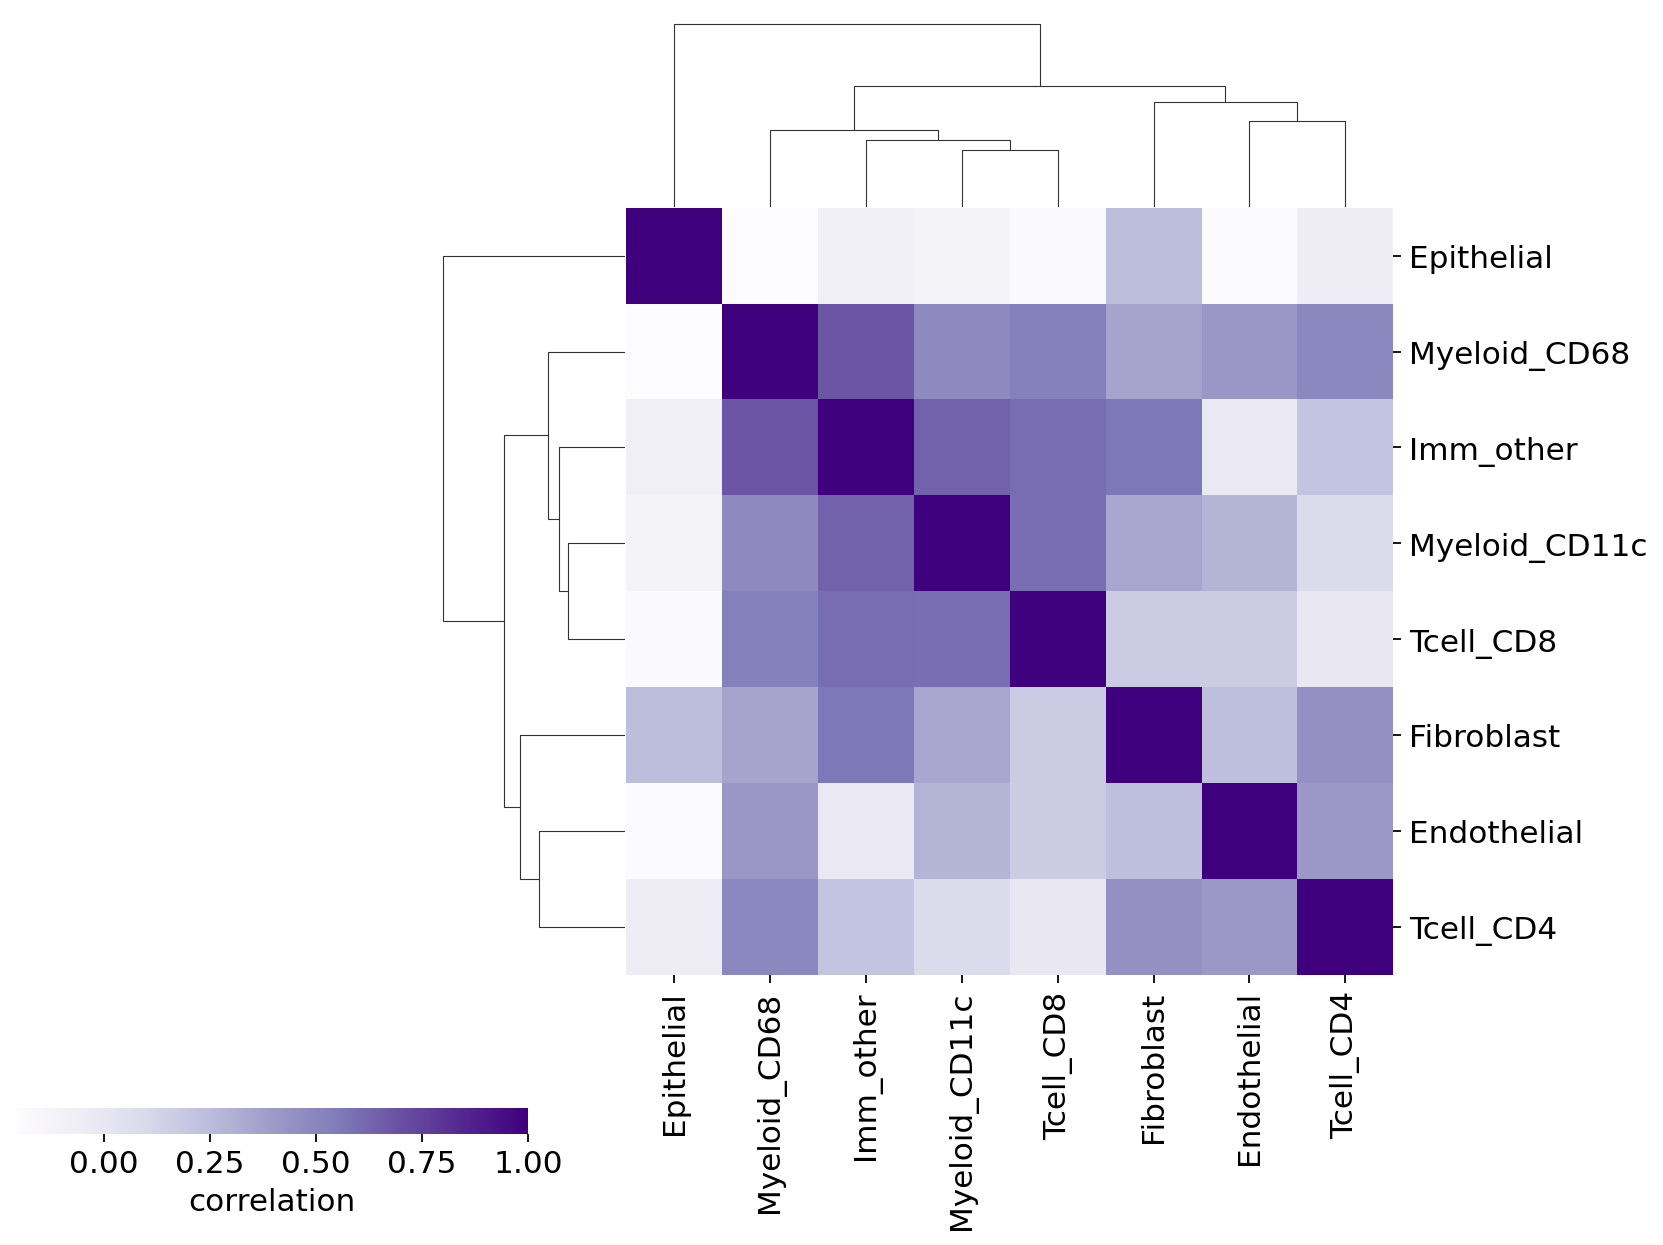

In [31]:
ncem.sender_similarity_analysis(receiver='Epithelial')